# Exploring the results

Here we find the confusion matrix and list of files that failed to be correctly classfied. 

### First training a model to test the results for

This model is purely an example to show how we will analyse the model.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
image_size = 150
input_size = image_size * image_size * 3  # Image size: 32x32 with 3 color channels
hidden_size = 128
num_layers = 2
num_classes = 2
batch_size = 100
num_epochs = 10
learning_rate = 0.001

# Data transforms
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),     # Resize the image to 32x32
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize(            # Normalize image channels
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load the dataset
#train_dataset = ImageFolder("../foreign_vs_clear/train", transform=transform)
#test_dataset = ImageFolder("../foreign_vs_clear/test", transform=transform)

train_dataset = ImageFolder("C:/Users/hanna/Desktop/git/interiorcardamage/Data2/processed/train", transform=transform)
test_dataset = ImageFolder("C:/Users/hanna/Desktop/git/interiorcardamage/Data2/processed/test", transform=transform)

# Data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Recurrent neural network (RNN)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forwardOLD(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.rnn(x, h0.reshape(self.num_layers, x.size(0), self.hidden_size))
        out = self.fc(out[:, -1, :])

        return out

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.rnn(x.unsqueeze(1), h0)
        out = self.fc(out[:, -1, :])

        return out


# Initialize the model
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Reshape images
        images = images.view(-1, input_size)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch}], Loss: {loss.item():.4f}")


Epoch [0], Loss: 0.6951
Epoch [1], Loss: 0.6748
Epoch [2], Loss: 0.6297
Epoch [3], Loss: 0.6188
Epoch [4], Loss: 0.6011
Epoch [5], Loss: 0.5995
Epoch [6], Loss: 0.5819
Epoch [7], Loss: 0.5751
Epoch [8], Loss: 0.5580
Epoch [9], Loss: 0.5502


In [3]:

# Test the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        images = images.view(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f"Labels: {labels}")
        print(f"Predicted: {predicted}")

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")


Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Predicted: tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0])
Test Accuracy: 54.76%


### Confusion matrix

The matrix will have the following four squares:

1. True Positive (1, 1): This cell represents the cases where the model correctly predicts the positive class (e.g., presence of a certain condition) and the true label is indeed positive.
2. False Positive (0, 1) i.e. top right: This cell represents the cases where the model incorrectly predicts the positive class, but the true label is actually negative (a false alarm or Type I error).
3. True Negative (0, 0): This cell represents the cases where the model correctly predicts the negative class (e.g., absence of a certain condition) and the true label is indeed negative.
4. False Negative (1, 0) i.e bottom left: This cell represents the cases where the model incorrectly predicts the negative class, but the true label is actually positive (a missed detection or Type II error).

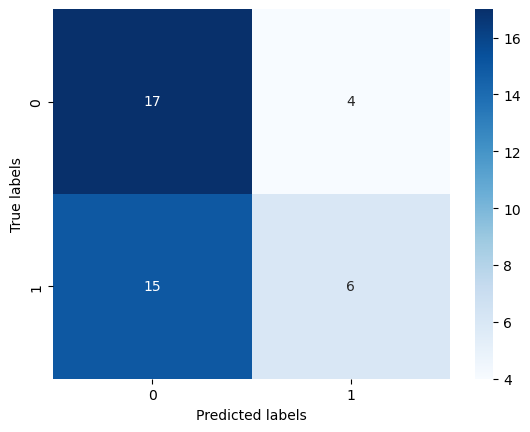

<AxesSubplot:xlabel='Predicted labels', ylabel='True labels'>

In [14]:
from sklearn.metrics import confusion_matrix 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, predicted)
cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
cm_percentages = np.round(cm_percentages, decimals=2)
#heatmap = sns.heatmap(cm_percentages, annot=True, fmt=".2%", cmap="Blues")
heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()
heatmap.figure.savefig("confusion_matrix.png") # rnn_not_clear_vs_clear.png

heatmap

In [18]:
cm[1][0]

15

In [16]:
from sklearn.metrics import classification_report
print( classification_report(labels, predicted) )

              precision    recall  f1-score   support

           0       0.53      0.81      0.64        21
           1       0.60      0.29      0.39        21

    accuracy                           0.55        42
   macro avg       0.57      0.55      0.51        42
weighted avg       0.57      0.55      0.51        42



### Finding the images incorrectly classified

In [5]:
test_filenames = [path for path, _ in test_dataset.imgs]
test_filenames

['C:/Users/hanna/Desktop/git/interiorcardamage/Data2/processed/test\\KnitCap\\KnitCap_000000.png',
 'C:/Users/hanna/Desktop/git/interiorcardamage/Data2/processed/test\\KnitCap\\KnitCap_000001.png',
 'C:/Users/hanna/Desktop/git/interiorcardamage/Data2/processed/test\\KnitCap\\KnitCap_000002.png',
 'C:/Users/hanna/Desktop/git/interiorcardamage/Data2/processed/test\\KnitCap\\KnitCap_000003.png',
 'C:/Users/hanna/Desktop/git/interiorcardamage/Data2/processed/test\\KnitCap\\KnitCap_000004.png',
 'C:/Users/hanna/Desktop/git/interiorcardamage/Data2/processed/test\\KnitCap\\KnitCap_000005.png',
 'C:/Users/hanna/Desktop/git/interiorcardamage/Data2/processed/test\\KnitCap\\KnitCap_000006.png',
 'C:/Users/hanna/Desktop/git/interiorcardamage/Data2/processed/test\\KnitCap\\KnitCap_000007.png',
 'C:/Users/hanna/Desktop/git/interiorcardamage/Data2/processed/test\\KnitCap\\KnitCap_000008.png',
 'C:/Users/hanna/Desktop/git/interiorcardamage/Data2/processed/test\\KnitCap\\KnitCap_000009.png',
 'C:/Users

In [12]:
import os
misclassified_filenames = []
for i in range(len(predicted)):
    if predicted[i] != labels[i]:
        misclassified_filenames.append(os.path.basename(test_filenames[i]))


In [13]:
misclassified_filenames

['KnitCap_000004.png',
 'KnitCap_000008.png',
 'KnitCap_000010.png',
 'KnitCap_000011.png',
 '000000.png',
 '000001.png',
 '000003.png',
 '000004.png',
 '000005.png',
 '000006.png',
 '000007.png',
 '000008.png',
 '000010.png',
 '000012.png',
 '000014.png',
 '000016.png',
 '000018.png',
 '000019.png',
 '000020.png']

In [10]:
import csv

file_path = "misclassified_filenames.csv" # rnn_misclassified_not_clear_vs_clear

with open(file_path, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Filename"]) 
    writer.writerows([[filename] for filename in misclassified_filenames])


### Final script for HPC

In [ ]:
'''
--------------------------------- Exploring -----------------------------------------
'''

from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the tensors 'labels' and 'predicted' on the GPU

# Move tensors from GPU to CPU
labels = labels.cpu()
predicted = predicted.cpu()

# Calculate the confusion matrix
cm = confusion_matrix(labels.numpy(), predicted.numpy())

# Convert the raw numbers to percentages
cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_percentages = np.round(cm_percentages, decimals=2)

# Plot the confusion matrix as a heatmap
#heatmap = sns.heatmap(cm_percentages, annot=True, fmt=".2%", cmap="Blues")
heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()
heatmap.figure.savefig("rnn_not_clear_vs_clear.png")

# Rest of the code for saving misclassified filenames


test_filenames = [path for path, _ in test_dataset.imgs]

import os
misclassified_filenames = []
for i in range(len(predicted)):
    if predicted[i] != labels[i]:
        misclassified_filenames.append(os.path.basename(test_filenames[i]))

import csv

file_path = "rnn_misclassified_not_clear_vs_clear.csv"

with open(file_path, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Filename"])
    writer.writerows([[filename] for filename in misclassified_filenames])

from sklearn.metrics import classification_report
print( classification_report(labels, predicted) )